# Gaussian Process Regression

Gaussian Processes are a non-parametric probabilistic modelling method that under some assumptions provide a flexible data model with hyperparameters that can be regressed to data in either an optimization or marginalization paradigm.

An extension of the usual parameter inference of kernel hyperparameters employed in GPR is to consider a Bayesian Model Selection of the choice of Kernel itself {cite}`simpson2021marg, Kroupa_2024`.

We will use this problem to demonstrate implementation of a model that has combinatorial degeneracy in it's parameters, and how to suppress this issue. Think _sorted_ priors or _forced identifiability transforms_ for those familiar with other popular NS implementations.

As an aside we use `uv` in this case to do package management, which can be useful if using hosted notebooks

In [ ]:
!pip install git+https://github.com/handley-lab/blackjax
!pip install tqdm numpy anesthetic tinygp tensorflow_probability matplotlib

In [ ]:
import jax
import jax.numpy as jnp
import tinygp
import blackjax
import matplotlib.pyplot as plt
import tqdm
import tensorflow_probability.substrates.jax as tfp
from blackjax.ns.utils import finalise, sample
from functools import partial


tfd = tfp.distributions
tfb = tfp.bijectors
rng_key = jax.random.PRNGKey(0)

In [21]:
print(f"Running example on an {jax.devices()[0].device_kind} GPU")

Running example on an NVIDIA L4 GPU


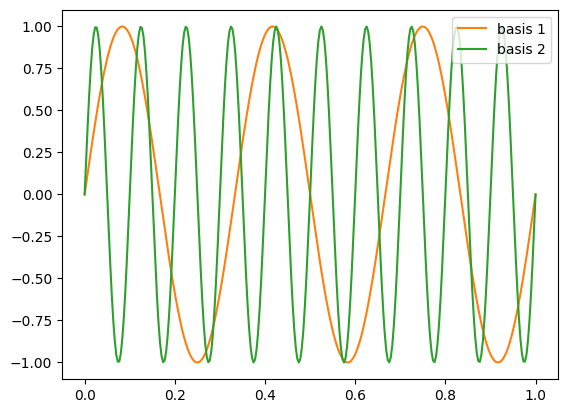

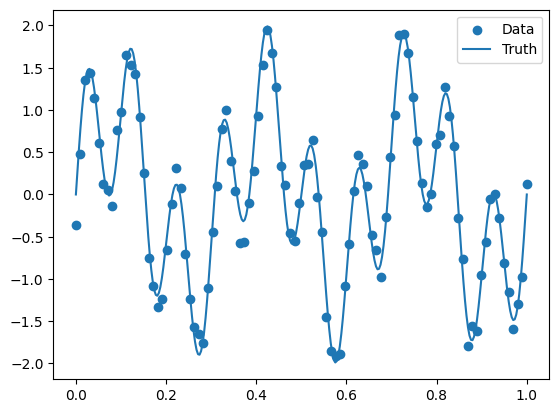

In [22]:

x_min = 0.0
x_max = 1.0
noise_level = 0.15
true_freqs = [3.0, 10]
x = jnp.linspace(x_min, x_max, 100)


def function(x, freqs):
    return jnp.sum(
        jnp.sin(2 * jnp.pi * x[:, None] * jnp.array(freqs)), axis=-1
    )

rng_key, data_key = jax.random.split(rng_key)
y = (
    function(x, true_freqs)
    + jax.random.normal(data_key, x.shape[0]) * noise_level
)
x_plot=jnp.linspace(0,1,300)
f,a=plt.subplots()
a.plot(x_plot,function(x_plot, true_freqs[0]), c="C1", label="basis 1")
a.plot(x_plot,function(x_plot, true_freqs[1]), c="C2", label="basis 2")

a.legend()

f,a=plt.subplots()

a.scatter(x,y, c="C0", label="Data")

# plt.plot(x_plot,function(x_plot, true_freqs[0]), c="C1", label="basis 1")
# plt.plot(x_plot,function(x_plot, true_freqs[1]), c="C2", label="basis 2")
a.plot(x_plot,function(x_plot, true_freqs), c="C0", label="Truth")
a.legend()


## GP Likelihood and Priors

We will use the `tinygp` library to provide the kernel and GP implementation, closely following the [Spectral Kernel Tutorial](https://tinygp.readthedocs.io/en/stable/benchmarks.html#benchmarks) on the `tinygp` docs. The Kernel function describing correlations on a length scale $\tau$ is defined as,

$$
k(\tau) = \sum^N_i w_i \cos(2\pi\tau\mu_{i}) \exp (-2\pi^2\tau^2\sigma_{i})\,,
$$
Where we can identify a weight $w$ being applied to a Gaussian in fourier space at frequency $\mu$ and with a variance $\sigma$. There are then $N\times3$ hyperparameters to fit, where $N$ is the number of degenerate basis functions we choose to paramaterize our distribution by. We will also introduce a global noise added to the diagonal of the covariance induced by the spectral kernel.


In [23]:
class SpectralMixtureKernel(tinygp.kernels.Kernel):
    weight: jax.Array
    scale: jax.Array
    freq: jax.Array

    def evaluate(self, X1, X2):
        tau = jnp.atleast_1d(jnp.abs(X1 - X2))[..., None]
        return jnp.sum(
            self.weight
            * jnp.prod(
                jnp.exp(-2 * jnp.pi**2 * tau * 2 / self.scale * 2)
                * jnp.cos(2 * jnp.pi * self.freq * tau),
                axis=0,
            )
        )

def build_gp(params):
    kernel = SpectralMixtureKernel(
        jnp.exp(params["weight"]),
        jnp.exp(params["scale"]),
        params["freq"],
    )
    process = tinygp.GaussianProcess(
        kernel,
        x,
        diag=jnp.exp(params["noise"]),
    )
    return process


@jax.jit
def loglikelihood(theta):
    logl = build_gp(theta).log_probability(y)
    return logl

Now we declare a prior for this process, where we will use a Uniform prior over a reasonable range of frequencies and a lognormal prior on all other parameters. It is convenient to use a structured joint distribution to do this, and we use `tensorflow-probability` for this in this instance. To tell the sampler how to translate to this structure from a flat vector we will use the inbuilt `jax.flatten_util.ravel_pytree` to get the reverse of a tree flatten, so should match any internals of the `blackjax` code.

In [24]:
fundamental_freq = 1 / (x.max() - x.min())
sampling_freq = x.shape[0] * fundamental_freq


def build_prior(n_components):
    # Define individual priors
    weight_prior = tfd.Normal(
        loc=jnp.zeros(n_components),
        scale=jnp.ones(n_components),
    )
    scale_prior = tfd.Normal(
            loc=jnp.zeros(n_components),
            scale=jnp.ones(n_components),
        )
    freq_prior = tfd.Uniform(
        low=jnp.ones(n_components) * fundamental_freq,
        high=jnp.ones(n_components) * sampling_freq / 2,
    )

    noise_prior = tfd.Uniform(
        low=0.0,
        high=1.0,
    )

    # Define joint distribution for sampling
    prior = tfd.JointDistributionNamed(
        {
            "weight": weight_prior,
            "scale": scale_prior,
            "freq": freq_prior,
            "noise": noise_prior,
        }
    )

    # Manual log probability function
    def log_prob(params):
        """Calculate the log probability of the parameters.

        Args:
            params: Dictionary with keys 'weight', 'scale', 'freq', and 'noise'

        Returns:
            Total log probability
        """
        total_log_prob = 0.0
        total_log_prob += weight_prior.log_prob(params["weight"]).sum()
        total_log_prob += freq_prior.log_prob(params["freq"]).sum()
        total_log_prob += scale_prior.log_prob(params["scale"]).sum()
        total_log_prob += noise_prior.log_prob(params["noise"]).sum()
        return total_log_prob

    return prior, log_prob


prior, log_prob = build_prior(n_components=2)


## Sampling

Finally we will pass all of this into the standard boilerplate Nested Sampling algorithm, where we 'oversample' the prior to hot start the sampler (technically the discarded points should be appended to the dead points but for brevity we omit this).

In [25]:
test_sample, _= jax.flatten_util.ravel_pytree(
    prior.sample(seed=jax.random.PRNGKey(0))
)
n_dims = test_sample.shape[0]
n_initial = 10000

n_live = 1000
n_delete = 500

num_mcmc_steps = n_dims * 3

# | Initialize the Nested Sampling algorithm
nested_sampler = blackjax.nss(
    logprior_fn=log_prob,
    loglikelihood_fn=loglikelihood,
    num_delete=n_delete,
    num_inner_steps=num_mcmc_steps,
)

def integrate(nested_sampler,rng_key, sort=False):
    rng_key, init_key = jax.random.split(rng_key, 2)
    particles = prior.sample(seed=init_key, sample_shape=(n_initial,))
    if sort:
      idx = jnp.argsort(particles["freq"])
      particles["freq"] = jnp.take_along_axis(particles["freq"], idx, -1)
      particles["weight"] = jnp.take_along_axis(particles["weight"], idx, -1)
      particles["scale"] = jnp.take_along_axis(particles["scale"], idx, -1)
    logl = jax.vmap(loglikelihood)(particles)
    top_logl, idx = jax.lax.top_k(logl, n_live)
    state = nested_sampler.init(
        jax.tree_util.tree_map(lambda leaf: leaf[idx], particles)
    )


    @jax.jit
    def one_step(carry, xs):
        state, k = carry
        k, subk = jax.random.split(k, 2)
        state, dead_point = nested_sampler.step(subk, state)
        return (state, k), dead_point

    dead = []
    with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
        while not state.logZ_live - state.logZ < -3:
            (state, rng_key), dead_info = one_step((state, rng_key), None)
            dead.append(dead_info)
            pbar.update(n_delete)

    return state, finalise(state, dead)

In [26]:
state, final = integrate(nested_sampler,rng_key)

Dead points: 20500 dead points [00:18, 1101.38 dead points/s]


We can inspect the predicted form of the functional fit, shown crudely here with an averaged error bar on each individual process. And the value we quote for $\ln Z$ can give us a method to compare to other kernels fit to this dataset. We additionally use Anesthetic to examine some example corner plots to diagnose the fitted parameter values, we will construct a reusable plot function for this

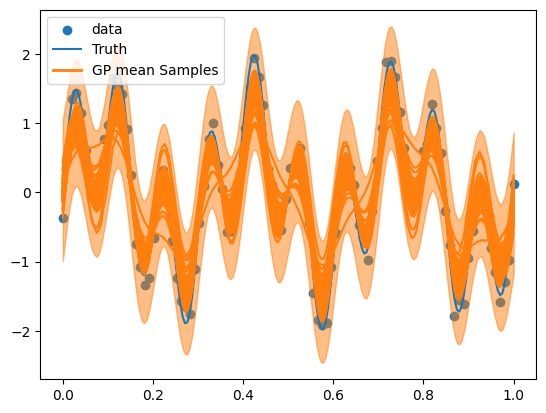

In [27]:
@jax.jit
def predict(theta, x_new):
    return build_gp(theta).predict(y, x_new, return_var=True)


def plot(rng_key, final):
  rng_key, sample_key = jax.random.split(rng_key)
  posterior_samples = sample(rng_key, final, 100)
  x_new = jnp.linspace(x_min, x_max, 200)
  pred = partial(predict, x_new=x_new)

  y_new, y_var_new = jax.vmap(pred)(posterior_samples)

  f, a = plt.subplots()
  a.scatter(x, y, c="C0", label="data")
  a.plot(x_new, function(x_new, true_freqs), c="C0", label="Truth")
  a.plot(x_new, y_new.T, c="C1")
  from matplotlib.lines import Line2D
  # Create a custom proxy artist for the GP samples
  custom_line = Line2D([0], [0], color="C1", lw=2)
  # Combine all handles and labels for the legend
  handles, labels = a.get_legend_handles_labels()
  handles.append(custom_line)
  labels.append("GP mean Samples")

  example_mean_prediction = y_new.mean(axis=0)
  example_var_prediction = jnp.sqrt(y_var_new.mean(axis=0))
  upper_bound = example_mean_prediction + 2 * example_var_prediction
  lower_bound = example_mean_prediction - 2 * example_var_prediction
  a.fill_between(x_new, lower_bound, upper_bound, color="C1", alpha=0.5, label="Uncertainty (±σ)")


  # Create the combined legend
  a.legend(handles, labels)
  f.savefig("GP.png")

plot(rng_key,final)



We can ask for two useful statistics as a product of a run now, the evidence which we can use to compare kernels, and the number of evaluations as a proxy for efficiency:

In [28]:
print(f"log evidence = {state.logZ:.2f}")
print(f"total evals = {final.inner_kernel_info.info.evals.sum()}")

log evidence = -136.53
total evals = 2252788


We can lastly plot the corner plot of the inferred frequencies and see if they mirror the known inserted values, However we see there is a problem in the parameterization of our model, we were fitting two degenerate basis functions and have ended up with 2 copies of the posterior.

,$\mu_0$,$\mu_1$
$\mu_0$,DiagonalAx...,OffDiagona...
$\mu_1$,OffDiagona...,DiagonalAx...


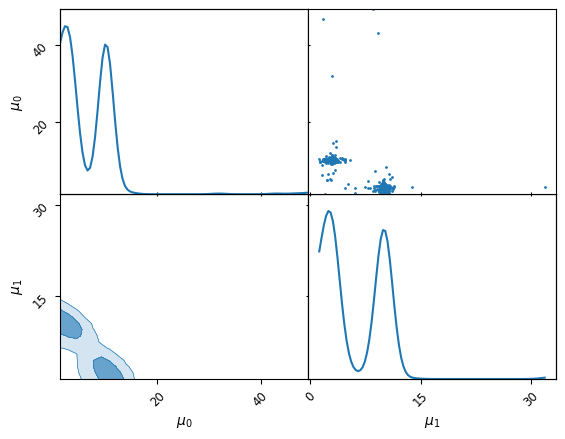

In [29]:
from anesthetic import MCMCSamples
posterior_samples = sample(rng_key, final, 500)

MCMCSamples(posterior_samples["freq"], columns=[r"$\mu_{}$".format(i) for i in range(n_components)]).plot_2d()

# Label Switching (Forced identifiability)

This is a good canvas to discuss how to approach the label switching problem. An illustration of this is visible in the corner plot of frequency where 2 identical modes are present. As we are fitting Gaussian basis functions, there is a $N!$ degeneracy in the parameter space. For $N=2$ this is not disasterous, but sampling will quickly become innefficient for higher numbers of basis functions.

There are a few options to address this, forced identifiability is a common transform to map the uniform hypercube over frequency to a simplex space, however this can have unpleasant effects on posterior geometry. In this example we will take a simpler effective approach of simply enforcing a sort in the covariance tuning. To do this we will overwrite the tuning function in the `nss` algorithm to account for this.

In [30]:
def sorted_stepper(x, n, t):
    y = jax.tree.map(lambda x, n: x + t * n, x, n)
    idx = jnp.argsort(y["freq"])
    y["freq"] = jnp.take_along_axis(y["freq"], idx, -1)
    y["weight"] = jnp.take_along_axis(y["weight"], idx, -1)
    y["scale"] = jnp.take_along_axis(y["scale"], idx, -1)
    return y

nested_sampler = blackjax.nss(
    logprior_fn=lambda x: prior.log_prob(x).sum(),
    loglikelihood_fn=loglikelihood,
    num_delete=n_delete,
    num_inner_steps=num_mcmc_steps,
    stepper_fn = sorted_stepper
    )

state, final = integrate(nested_sampler,rng_key, sort=True)


Dead points: 20000 dead points [00:18, 1080.97 dead points/s]


We can reuse our previous plotting and evaluation. We take more evaluations but achieve a similar functional form.

log evidence = -135.53
total evals = 2011645


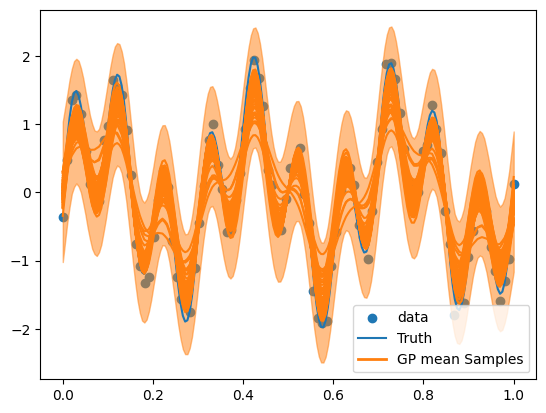

In [31]:
plot(rng_key,final)
print(f"log evidence = {state.logZ:.2f}")
print(f"total evals = {final.inner_kernel_info.info.evals.sum()}")

Importantly if we inspect the corner plot of the frequencies, it appears that we have succesfully identified a single mode with frequencies matching the input $\mu_0=3.0,\mu_1=10.0$

,$\mu_0$,$\mu_1$
$\mu_0$,DiagonalAx...,OffDiagona...
$\mu_1$,OffDiagona...,DiagonalAx...


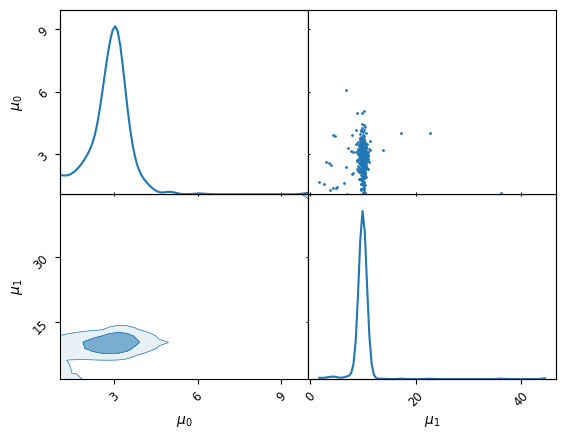

In [32]:
from anesthetic import MCMCSamples
posterior_samples = sample(rng_key, final, 500)

MCMCSamples(posterior_samples["freq"], columns=[r"$\mu_{}$".format(i) for i in range(n_components)]).plot_2d()